In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:

# List of species
species_list = [
    'Alstonia Scholaris (P2)', 'Arjun (P1)', 'Chinar (P11)', 
    'Guava (P3)', 'Jamun (P5)', 'Jatropha (P6)', 'Lemon (P10)',
    'Mango (P0)', 'Pomegranate (P9)', 'Pongamia Pinnata (P7)'
]
species_map = {species: idx for idx, species in enumerate(species_list)}
status_map = {'healthy': 0, 'diseased': 1}

In [8]:
# Prepare dataset
base_path = "./data/computer-vision-xm/database4leaf-images"
data_rows = []

for species in species_list:
    species_path = os.path.join(base_path, species).replace('\\','/')
    if not os.path.exists(species_path):
        continue

    # Get species index
    species_idx = species_map[species]

    # Process healthy and diseased folders
    for status in ['healthy', 'diseased']:
        status_path = os.path.join(species_path, status).replace('\\','/')
        if not os.path.exists(status_path):
            continue

        status_label = status_map[status]
        # Get all images in the folder
        for img_name in os.listdir(status_path):
            if img_name.endswith(('.jpg', '.JPG')):
                img_path = os.path.join(status_path, img_name).replace('\\','/')
                data_rows.append({
                    'image_path': img_path,
                    'image_name': img_name,
                    'status_label': status_label,
                    'type_label': species_idx,
                    'species_name': species
                })

In [9]:
# Load and preprocess images
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess a single image"""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

# Create TensorFlow dataset
# First, calculate the steps per epoch based on your dataset size and batch size
BATCH_SIZE = 32

def create_tf_dataset(df, batch_size=32, is_training=False):
    """Create a TensorFlow dataset from DataFrame with proper repeat for training"""
    def generator():
        while True:  # This creates an infinite generator
            if is_training:
                df_shuffled = df.sample(frac=1).reset_index(drop=True)
            else:
                df_shuffled = df
                
            for _, row in df_shuffled.iterrows():
                img = load_and_preprocess_image(row['image_path'])
                yield (
                    img, 
                    {
                        'leaf_output': row['type_label'],
                        'disease_output': row['status_label']
                    }
                )
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            {
                'leaf_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                'disease_output': tf.TensorSpec(shape=(), dtype=tf.int32)
            }
        )
    )

    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    
    # Add prefetch to optimize performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [10]:
df = pd.DataFrame(data_rows)

# Split into train, validation, and test sets
test_size = 0.2
val_size = 0.2

train_df, test_df = train_test_split(df, test_size=test_size, stratify=df[['type_label', 'status_label']])
train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=train_df[['type_label', 'status_label']])

# Calculate steps per epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

# Create datasets
train_dataset = create_tf_dataset(train_df, batch_size=BATCH_SIZE, is_training=True)
val_dataset = create_tf_dataset(val_df, batch_size=BATCH_SIZE, is_training=False)
test_dataset = create_tf_dataset(test_df, batch_size=BATCH_SIZE, is_training=False)



In [6]:
# Create the combined model
def create_combined_model(num_classes, input_shape=(224, 224, 3)):
    """Creates a combined model for classifying leaf species and health status."""
    # Create the base model
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model

    # Add Global Average Pooling to reduce the output dimensions
    x = layers.GlobalAveragePooling2D()(base_model.output)
    
    # Add a dense layer to help with feature extraction
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Create separate dense layers for leaf type and disease status
    leaf_output = layers.Dense(num_classes, activation='softmax', name='leaf_output')(x)
    disease_output = layers.Dense(2, activation='softmax', name='disease_output')(x)

    model = tf.keras.Model(
        inputs=base_model.input, 
        outputs=[leaf_output, disease_output]
    )
    return model



The complete data flow is now:

Input image: (batch_size, 224, 224, 3)
EfficientNetB0: → (batch_size, 7, 7, 1280)
GlobalAveragePooling2D: → (batch_size, 1280)
Dense + Dropout: → (batch_size, 512)
Output layers:

Leaf classification: → (batch_size, num_classes)
Disease status: → (batch_size, 2)

In [7]:
# Update the model creation and compilation
num_leaf_classes = len(species_list)
combined_model = create_combined_model(num_leaf_classes)

# Define loss weights if you want to balance the importance of each task
combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'leaf_output': 'sparse_categorical_crossentropy',
        'disease_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'leaf_output': 1.0,
        'disease_output': 1.0
    },
    metrics={
        'leaf_output': 'accuracy',
        'disease_output': 'accuracy'
    }
)


In [8]:
# Perform initial training
# Training with proper steps_per_epoch
initial_epochs = 20
history = combined_model.fit(
    train_dataset,
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            './models/detect_plant_best_model.keras',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/20


2024-11-10 23:08:40.307020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 146 of 1000
2024-11-10 23:09:00.259061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 429 of 1000
2024-11-10 23:09:10.263793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 567 of 1000
2024-11-10 23:09:20.298841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 707 of 1000
2024-11-10 23:09:40.280449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 991 of 1000
2024-11-10 23:09:40.845693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1731298182.796235  105291 service.

 1/76 ━━━━━━━━━━━━━━━━━━━━ 1:49:51 88s/step - disease_output_accuracy: 0.5625 - disease_output_loss: nan - leaf_output_accuracy: 0.2188 - leaf_output_loss: 2.1999 - loss: nan

I0000 00:00:1731298191.261870  105291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - disease_output_accuracy: 0.5083 - disease_output_loss: nan - leaf_output_accuracy: 0.1525 - leaf_output_loss: nan - loss: nan - val_disease_output_accuracy: 0.5132 - val_disease_output_loss: nan - val_leaf_output_accuracy: 0.1546 - val_leaf_output_loss: nan - val_loss: nan
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - disease_output_accuracy: 0.5114 - disease_output_loss: nan - leaf_output_accuracy: 0.1633 - leaf_output_loss: nan - loss: nan - val_disease_output_accuracy: 0.5164 - val_disease_output_loss: nan - val_leaf_output_accuracy: 0.1579 - val_leaf_output_loss: nan - val_loss: nan
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - disease_output_accuracy: 0.5127 - disease_output_loss: nan - leaf_output_accuracy: 0.1488 - leaf_output_loss: nan - loss: nan - val_disease_output_accuracy: 0.5148 - val_disease_output_loss: nan - val_leaf_output_accuracy: 0.1546 - val_leaf_output_loss: nan - val_loss: nan
Epoch 4/20
76/76 ━━━━━━━━━━━━━

In [9]:
# Fine-tuning
combined_model.trainable = True
for layer in combined_model.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate
combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        'leaf_output': 'sparse_categorical_crossentropy',
        'disease_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'leaf_output': 1.0,
        'disease_output': 1.0
    },
    metrics={
        'leaf_output': 'accuracy',
        'disease_output': 'accuracy'
    }
)

# Fine-tuning training
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = combined_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            './models/detect_plant_best_model.keras',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 21/30


2024-11-10 23:26:13.746176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 138 of 1000
2024-11-10 23:26:23.765204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 274 of 1000
2024-11-10 23:26:43.809977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 562 of 1000
2024-11-10 23:27:03.800831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 846 of 1000
2024-11-10 23:27:14.508741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


76/76 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - disease_output_accuracy: 0.5023 - disease_output_loss: nan - leaf_output_accuracy: 0.1602 - leaf_output_loss: nan - loss: nan - val_disease_output_accuracy: 0.5132 - val_disease_output_loss: nan - val_leaf_output_accuracy: 0.1546 - val_leaf_output_loss: nan - val_loss: nan
Epoch 22/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - disease_output_accuracy: 0.5065 - disease_output_loss: nan - leaf_output_accuracy: 0.1571 - leaf_output_loss: nan - loss: nan - val_disease_output_accuracy: 0.5164 - val_disease_output_loss: nan - val_leaf_output_accuracy: 0.1579 - val_leaf_output_loss: nan - val_loss: nan
Epoch 23/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - disease_output_accuracy: 0.5323 - disease_output_loss: nan - leaf_output_accuracy: 0.1602 - leaf_output_loss: nan - loss: nan - val_disease_output_accuracy: 0.5148 - val_disease_output_loss: nan - val_leaf_output_accuracy: 0.1546 - val_leaf_output_loss: nan - val_loss: nan
Epoch 24/30
76/76 ━━━━━━━━━━

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_training_history(history, fine_tuning_history=None):
    """Plot training history for both initial training and fine-tuning"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot leaf classification accuracy
    axes[0, 0].plot(history.history['leaf_output_accuracy'], label='Training')
    axes[0, 0].plot(history.history['val_leaf_output_accuracy'], label='Validation')
    if fine_tuning_history:
        axes[0, 0].plot(np.arange(len(history.history['leaf_output_accuracy']), 
                                 len(history.history['leaf_output_accuracy']) + len(fine_tuning_history.history['leaf_output_accuracy'])),
                       fine_tuning_history.history['leaf_output_accuracy'], label='Fine-tuning Training')
        axes[0, 0].plot(np.arange(len(history.history['val_leaf_output_accuracy']), 
                                 len(history.history['val_leaf_output_accuracy']) + len(fine_tuning_history.history['val_leaf_output_accuracy'])),
                       fine_tuning_history.history['val_leaf_output_accuracy'], label='Fine-tuning Validation')
    axes[0, 0].set_title('Leaf Classification Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    
    # Plot disease classification accuracy
    axes[0, 1].plot(history.history['disease_output_accuracy'], label='Training')
    axes[0, 1].plot(history.history['val_disease_output_accuracy'], label='Validation')
    if fine_tuning_history:
        axes[0, 1].plot(np.arange(len(history.history['disease_output_accuracy']), 
                                 len(history.history['disease_output_accuracy']) + len(fine_tuning_history.history['disease_output_accuracy'])),
                       fine_tuning_history.history['disease_output_accuracy'], label='Fine-tuning Training')
        axes[0, 1].plot(np.arange(len(history.history['val_disease_output_accuracy']), 
                                 len(history.history['val_disease_output_accuracy']) + len(fine_tuning_history.history['val_disease_output_accuracy'])),
                       fine_tuning_history.history['val_disease_output_accuracy'], label='Fine-tuning Validation')
    axes[0, 1].set_title('Disease Classification Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # Plot total loss
    axes[1, 0].plot(history.history['loss'], label='Training')
    axes[1, 0].plot(history.history['val_loss'], label='Validation')
    if fine_tuning_history:
        axes[1, 0].plot(np.arange(len(history.history['loss']), 
                                 len(history.history['loss']) + len(fine_tuning_history.history['loss'])),
                       fine_tuning_history.history['loss'], label='Fine-tuning Training')
        axes[1, 0].plot(np.arange(len(history.history['val_loss']), 
                                 len(history.history['val_loss']) + len(fine_tuning_history.history['val_loss'])),
                       fine_tuning_history.history['val_loss'], label='Fine-tuning Validation')
    axes[1, 0].set_title('Total Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    
    plt.tight_layout()
    plt.show()



In [11]:
def predict_and_evaluate(model, test_dataset, test_df, species_list):
    """Make predictions and evaluate the model"""
    # Get predictions
    predictions = model.predict(test_dataset, steps=len(test_df) // BATCH_SIZE)
    leaf_predictions = predictions[0]
    disease_predictions = predictions[1]
    
    # Convert predictions to class labels
    leaf_pred_classes = np.argmax(leaf_predictions, axis=1)
    disease_pred_classes = np.argmax(disease_predictions, axis=1)
    
    # Get true labels
    true_leaf_classes = test_df['type_label'].values[:len(leaf_pred_classes)]
    true_disease_classes = test_df['status_label'].values[:len(disease_pred_classes)]
    
    # Calculate confusion matrices
    leaf_cm = confusion_matrix(true_leaf_classes, leaf_pred_classes)
    disease_cm = confusion_matrix(true_disease_classes, disease_pred_classes)
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Leaf species confusion matrix
    sns.heatmap(leaf_cm, annot=True, fmt='d', ax=ax1, 
                xticklabels=[s.split('(')[0].strip() for s in species_list],
                yticklabels=[s.split('(')[0].strip() for s in species_list])
    ax1.set_title('Leaf Species Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Disease status confusion matrix
    sns.heatmap(disease_cm, annot=True, fmt='d', ax=ax2,
                xticklabels=['Healthy', 'Diseased'],
                yticklabels=['Healthy', 'Diseased'])
    ax2.set_title('Disease Status Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification reports
    print("\nLeaf Species Classification Report:")
    print(classification_report(true_leaf_classes, leaf_pred_classes,
                              target_names=[s.split('(')[0].strip() for s in species_list]))
    
    print("\nDisease Status Classification Report:")
    print(classification_report(true_disease_classes, disease_pred_classes,
                              target_names=['Healthy', 'Diseased']))
    
    return leaf_pred_classes, disease_pred_classes




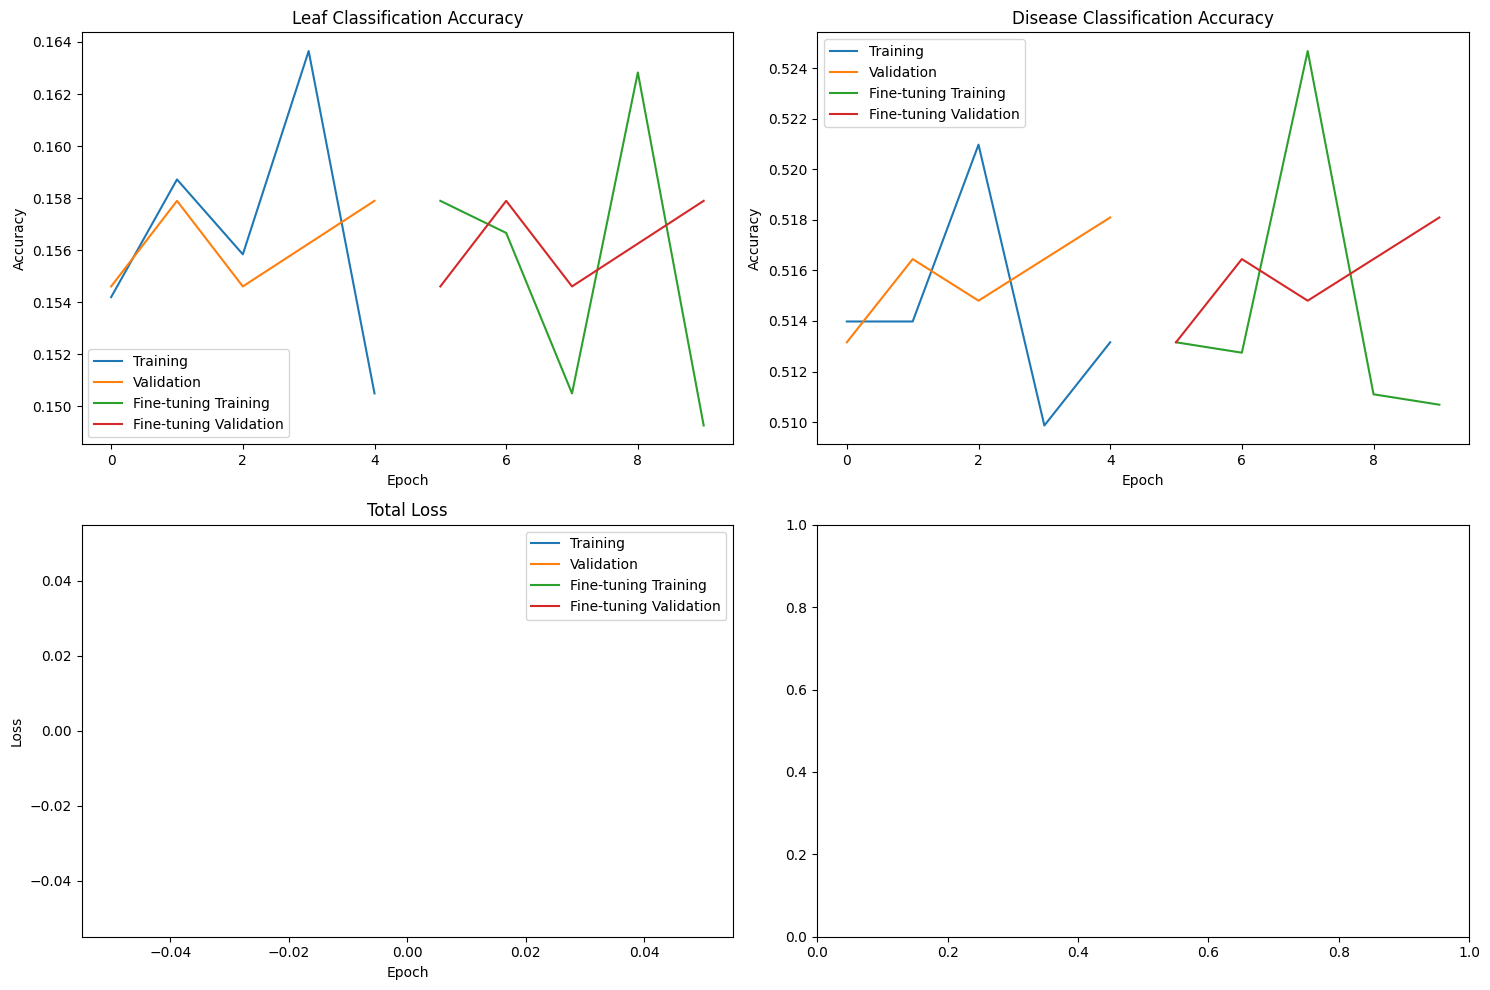

23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step


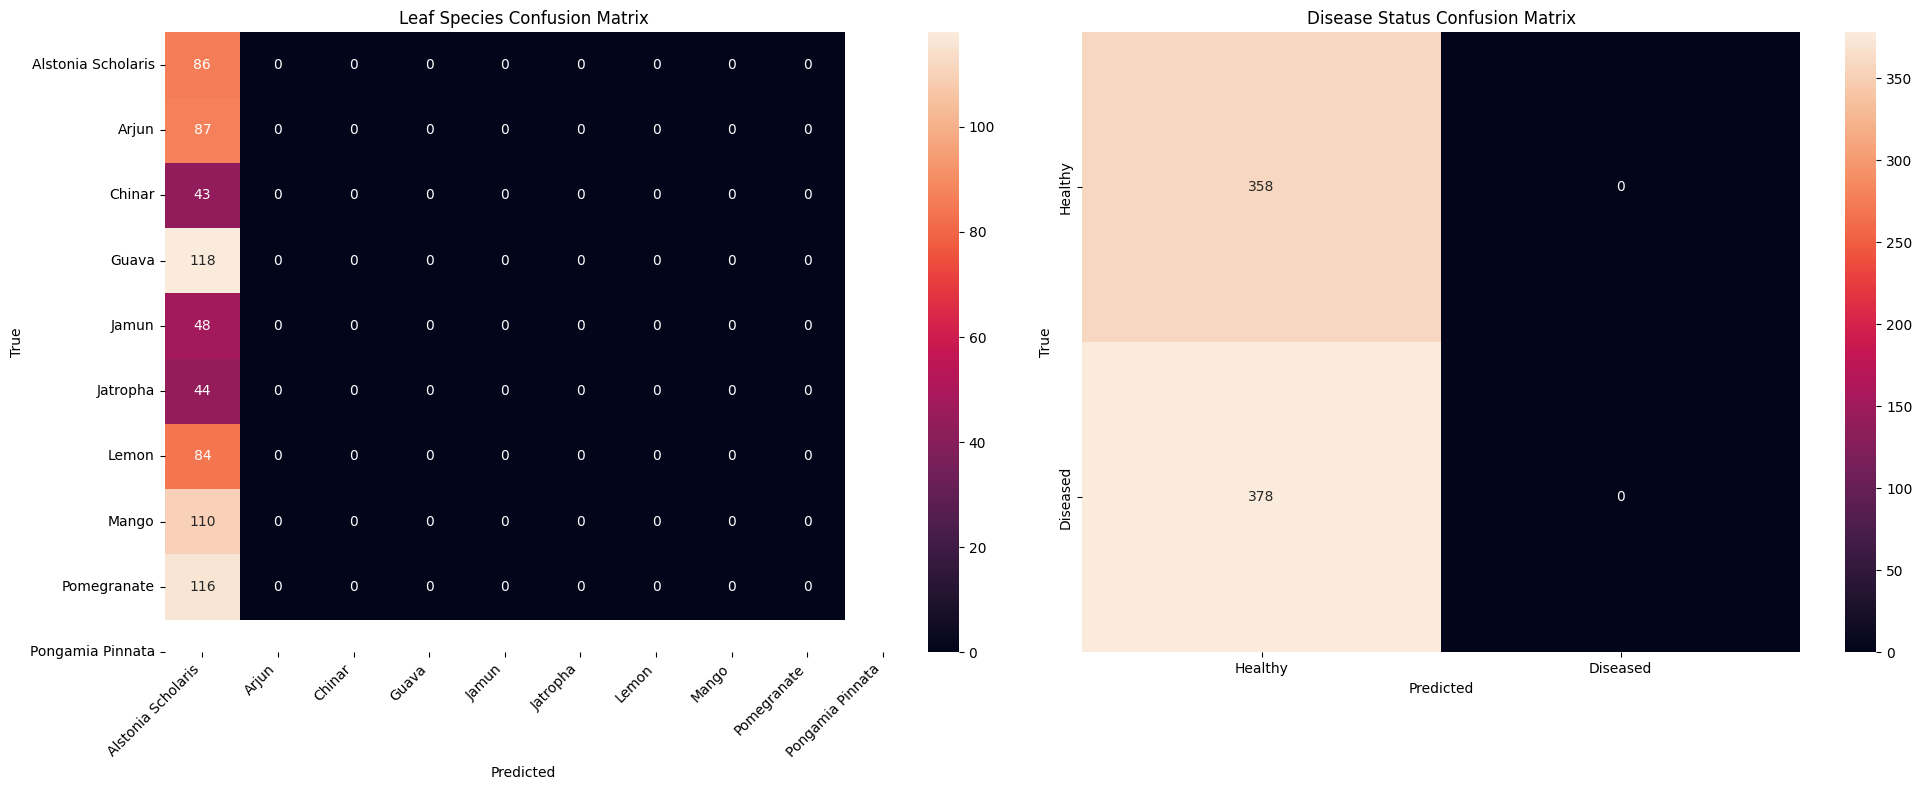


Leaf Species Classification Report:


ValueError: Number of classes, 9, does not match size of target_names, 10. Try specifying the labels parameter

In [12]:
def visualize_predictions(model, test_df, species_list, num_samples=5):
    """Visualize some example predictions"""
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))
    
    # Randomly sample some test images
    sample_indices = np.random.choice(len(test_df), num_samples, replace=False)
    
    for idx, sample_idx in enumerate(sample_indices):
        # Load and preprocess image
        img_path = test_df.iloc[sample_idx]['image_path']
        img = load_and_preprocess_image(img_path)
        
        # Make prediction
        predictions = model.predict(np.expand_dims(img, axis=0))
        leaf_pred = np.argmax(predictions[0][0])
        disease_pred = np.argmax(predictions[1][0])
        
        # Get true labels
        true_leaf = test_df.iloc[sample_idx]['type_label']
        true_disease = test_df.iloc[sample_idx]['status_label']
        
        # Display image and predictions
        display_img = plt.imread(img_path)
        axes[idx].imshow(display_img)
        axes[idx].axis('off')
        
        # Create title with predictions
        title = f"True: {species_list[true_leaf].split('(')[0].strip()} ({['Healthy', 'Diseased'][true_disease]})\n"
        title += f"Predicted: {species_list[leaf_pred].split('(')[0].strip()} ({['Healthy', 'Diseased'][disease_pred]})"
        
        # Color code the title based on correctness
        axes[idx].set_title(title, color='green' if (leaf_pred == true_leaf and disease_pred == true_disease) else 'red')
    
    plt.tight_layout()
    plt.show()

# Use the evaluation functions
# Plot training history
plot_training_history(history, history_fine)

# Make predictions and evaluate
leaf_preds, disease_preds = predict_and_evaluate(combined_model, test_dataset, test_df, species_list)

# Visualize some example predictions
visualize_predictions(combined_model, test_df, species_list)



In [ ]:
# Function to make predictions on new images
def predict_single_image(model, image_path, species_list):
    """Make predictions for a single image"""
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    
    # Make prediction
    predictions = model.predict(img)
    leaf_pred = np.argmax(predictions[0][0])
    disease_pred = np.argmax(predictions[1][0])
    
    # Get confidence scores
    leaf_confidence = predictions[0][0][leaf_pred] * 100
    disease_confidence = predictions[1][0][disease_pred] * 100
    
    # Print results
    print(f"Predicted Leaf Species: {species_list[leaf_pred]} (Confidence: {leaf_confidence:.2f}%)")
    print(f"Disease Status: {'Diseased' if disease_pred else 'Healthy'} (Confidence: {disease_confidence:.2f}%)")
    
    # Display the image with predictions
    plt.figure(figsize=(8, 8))
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.title(f"Prediction: {species_list[leaf_pred].split('(')[0].strip()}\n"
              f"Status: {'Diseased' if disease_pred else 'Healthy'}")
    plt.show()
    
    return leaf_pred, disease_pred, leaf_confidence, disease_confidence